In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import torch


/Users/kawtarissam/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kawtarissam/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Load dataset
df = pd.read_csv('Intent_detection_Data(Hoja1).csv', encoding='latin1')

# Map intents to numerical IDs
label2id = {label: idx for idx, label in enumerate(df["INTENT"].unique())}
id2label = {idx: label for label, idx in label2id.items()}
df["label"] = df["INTENT"].map(label2id)

# Display the first few rows of the dataset
print(df.head())


                                             REQUEST            INTENT  label
0  Good day! Are there any single phase equivalen...  CatalogSelection      0
1  Good day! I would like to ask for the differen...  CatalogSelection      0
2               hi do we have a current transformer?  CatalogSelection      0
3  Hi, may I ask if these items are still active,...  CatalogSelection      0
4  I am looking for a magnetic contactor for LC1K...  CatalogSelection      0


In [8]:
# Split dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["REQUEST"], df["label"], test_size=0.2, stratify=df["INTENT"], random_state=42
)


In [9]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label2id)
)

# Handle padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
# Create datasets from training and validation data
train_dataset = Dataset.from_dict({"REQUEST": train_texts.tolist(), "label": train_labels.tolist()})
val_dataset = Dataset.from_dict({"REQUEST": val_texts.tolist(), "label": val_labels.tolist()})


In [12]:
# Define tokenization function
def tokenize_function(examples):
    return tokenizer(examples["REQUEST"], padding="max_length", truncation=True, max_length=512)

# Apply tokenization to train and validation datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Format datasets for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map: 100%|██████████| 32/32 [00:00<00:00, 3349.75 examples/s]


In [13]:
# Adjust the model's token embeddings to match the tokenizer
model.resize_token_embeddings(len(tokenizer))


Embedding(30522, 768, padding_idx=0)

In [14]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="/Users/kawtarissam/Desktop/chatbot2/my_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=100,  # Adjust as needed
    log_level="info",
    no_cuda=True
)


/Users/kawtarissam/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/kawtarissam/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1583: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [25]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
import evaluate

# Load accuracy, F1, and recall from the 'evaluate' library
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")

# Function to compute metrics (accuracy, F1, and recall)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Get the predictions by selecting the class with the highest logit
    predictions = logits.argmax(axis=-1)

    # Calculate accuracy, F1 score, and recall
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_score(labels, predictions, average='weighted') 
    recall = recall_score(labels, predictions, average='weighted')  # Use 'weighted' for multiclass

    # Return all metrics in a dictionary
    return {
        "accuracy": accuracy["accuracy"],  # Accuracy value
        "f1": f1,                    # F1 score value
        "recall": recall,         # Recall value
    }

In [26]:
# Define data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    
)


In [27]:
trainer.train()


The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: REQUEST. If REQUEST are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 128
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 640
  Number of trainable parameters = 109,485,316
 16%|█▌        | 100/640 [04:12<22:43,  2.52s/it]

{'loss': 0.1523, 'grad_norm': 0.027053220197558403, 'learning_rate': 1.6875e-05, 'epoch': 0.78}


 20%|██        | 128/640 [05:21<21:10,  2.48s/it]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: REQUEST. If REQUEST are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 32
  Batch size = 1
                                                 
 20%|██        | 128/640 [05:35<21:10,  2.48s/it]

{'eval_loss': 1.0439343452453613, 'eval_accuracy': 0.84375, 'eval_f1': 0.8411345598845599, 'eval_recall': 0.84375, 'eval_runtime': 14.51, 'eval_samples_per_second': 2.205, 'eval_steps_per_second': 2.205, 'epoch': 1.0}


 31%|███▏      | 200/640 [08:39<20:42,  2.82s/it]

{'loss': 0.234, 'grad_norm': 0.00909459125250578, 'learning_rate': 1.375e-05, 'epoch': 1.56}


 40%|████      | 256/640 [11:13<14:29,  2.26s/it]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: REQUEST. If REQUEST are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 32
  Batch size = 1
                                                 
 40%|████      | 256/640 [11:27<14:29,  2.26s/it]

{'eval_loss': 0.7367440462112427, 'eval_accuracy': 0.90625, 'eval_f1': 0.9056919642857143, 'eval_recall': 0.90625, 'eval_runtime': 14.1536, 'eval_samples_per_second': 2.261, 'eval_steps_per_second': 2.261, 'epoch': 2.0}


 47%|████▋     | 300/640 [13:12<15:00,  2.65s/it]

{'loss': 0.0009, 'grad_norm': 0.0445997528731823, 'learning_rate': 1.0625e-05, 'epoch': 2.34}


 60%|██████    | 384/640 [16:46<10:14,  2.40s/it]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: REQUEST. If REQUEST are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 32
  Batch size = 1
                                                 
 60%|██████    | 384/640 [17:01<10:14,  2.40s/it]

{'eval_loss': 0.7845597863197327, 'eval_accuracy': 0.90625, 'eval_f1': 0.9056919642857143, 'eval_recall': 0.90625, 'eval_runtime': 14.4414, 'eval_samples_per_second': 2.216, 'eval_steps_per_second': 2.216, 'epoch': 3.0}


 62%|██████▎   | 400/640 [17:43<11:47,  2.95s/it]

{'loss': 0.0811, 'grad_norm': 0.03461292013525963, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.12}


 78%|███████▊  | 500/640 [22:29<05:55,  2.54s/it]Saving model checkpoint to /Users/kawtarissam/Desktop/chatbot2/my_model/checkpoint-500
Configuration saved in /Users/kawtarissam/Desktop/chatbot2/my_model/checkpoint-500/config.json


{'loss': 0.0618, 'grad_norm': 0.01889372617006302, 'learning_rate': 4.3750000000000005e-06, 'epoch': 3.91}


Model weights saved in /Users/kawtarissam/Desktop/chatbot2/my_model/checkpoint-500/model.safetensors
 80%|████████  | 512/640 [23:00<05:13,  2.45s/it]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: REQUEST. If REQUEST are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 32
  Batch size = 1
                                                 
 80%|████████  | 512/640 [23:15<05:13,  2.45s/it]

{'eval_loss': 0.74285489320755, 'eval_accuracy': 0.90625, 'eval_f1': 0.9056919642857143, 'eval_recall': 0.90625, 'eval_runtime': 15.168, 'eval_samples_per_second': 2.11, 'eval_steps_per_second': 2.11, 'epoch': 4.0}


 94%|█████████▍| 600/640 [26:48<01:35,  2.39s/it]

{'loss': 0.0005, 'grad_norm': 0.01071951724588871, 'learning_rate': 1.25e-06, 'epoch': 4.69}


100%|██████████| 640/640 [28:30<00:00,  2.78s/it]Saving model checkpoint to /Users/kawtarissam/Desktop/chatbot2/my_model/checkpoint-640
Configuration saved in /Users/kawtarissam/Desktop/chatbot2/my_model/checkpoint-640/config.json
Model weights saved in /Users/kawtarissam/Desktop/chatbot2/my_model/checkpoint-640/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: REQUEST. If REQUEST are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 32
  Batch size = 1
                                                 
100%|██████████| 640/640 [28:46<00:00,  2.78s/it]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 640/640 [28:46<00:00,  2.70s/it]

{'eval_loss': 0.7576940655708313, 'eval_accuracy': 0.90625, 'eval_f1': 0.9056919642857143, 'eval_recall': 0.90625, 'eval_runtime': 14.3718, 'eval_samples_per_second': 2.227, 'eval_steps_per_second': 2.227, 'epoch': 5.0}
{'train_runtime': 1726.8928, 'train_samples_per_second': 0.371, 'train_steps_per_second': 0.371, 'train_loss': 0.0829406609205762, 'epoch': 5.0}


TrainOutput(global_step=640, training_loss=0.0829406609205762, metrics={'train_runtime': 1726.8928, 'train_samples_per_second': 0.371, 'train_steps_per_second': 0.371, 'total_flos': 168394099261440.0, 'train_loss': 0.0829406609205762, 'epoch': 5.0})

In [18]:
model.save_pretrained("./my_model")  # Saving the model
tokenizer.save_pretrained("./my_model")  #  tokenizer

Configuration saved in ./my_model/config.json
Model weights saved in ./my_model/model.safetensors
tokenizer config file saved in ./my_model/tokenizer_config.json
Special tokens file saved in ./my_model/special_tokens_map.json


('./my_model/tokenizer_config.json',
 './my_model/special_tokens_map.json',
 './my_model/vocab.txt',
 './my_model/added_tokens.json',
 './my_model/tokenizer.json')

In [29]:
results = trainer.evaluate()
print(results)

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: REQUEST. If REQUEST are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 32
  Batch size = 1
100%|██████████| 32/32 [00:13<00:00,  2.35it/s]

{'eval_loss': 0.7576940655708313, 'eval_accuracy': 0.90625, 'eval_f1': 0.9056919642857143, 'eval_recall': 0.90625, 'eval_runtime': 14.1411, 'eval_samples_per_second': 2.263, 'eval_steps_per_second': 2.263, 'epoch': 5.0}


In [30]:
import matplotlib
import pandas as pd
df = pd.DataFrame([results])

In [31]:
df.to_csv("BERT_evaluation_results.csv", index=False)


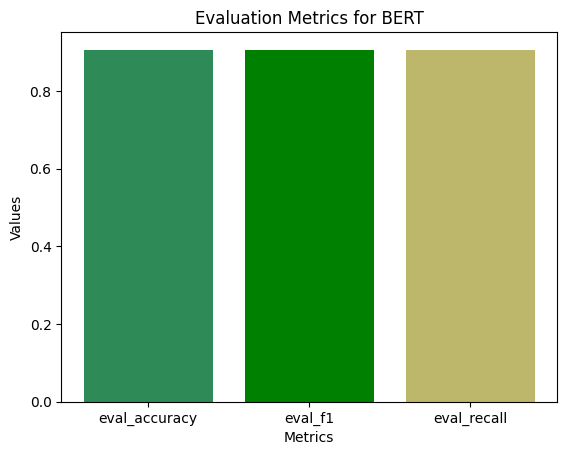

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

metrics = ['eval_accuracy', 'eval_f1', 'eval_recall']
values = df[metrics].iloc[0]  
plt.bar(metrics, values, color=['seagreen', 'green', 'darkkhaki'])


plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics for BERT')

plt.show()
